# save data in new directory

In [43]:
"""
A: cross_attn
B: concatenation
C: fc_layer

D: cross_attn, 5-fold
E: concatenation
F: fc_layer

G: adversarial

H: cross_attn, save embeddings, 1 epoch
I: concatenation, save embeddings, 1 epoch
J: fc_layer, save embeddings, 1 epoch

K: cross_attn, save embeddings, 5 epoch
L: concatenation, save embeddings, 5 epoch
M: fc_layer, save embeddings, 5 epoch

N: adversarial, cross_attn
O: adversarial, concatenation
P: adversarial, fc_layer

Q: baseline resnet
R: finetuned resnet

S: finetuned resnet with IPW, imbalanced test set
T: finetuned resnet with IPW, balanced test set
"""

version = 'T'
prefix = f'may10_{version}'
path = prefix
import os
os.makedirs(path)

# import statements and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import torch
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split

In [2]:
image_dir = 'images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

torch.manual_seed(42)
np.random.seed(42)

Using cuda device.


In [3]:
labels = pd.read_csv('features.csv')
labels = labels[['patient','dm_time', 'age', 'educational_level', 'sex']]
labels = labels.set_index('patient')
labels.head()

,dm_time,age,educational_level,sex
patient,,,,
1,15.0,58,3.0,1
10,7.0,63,2.0,0
100,1.0,66,1.0,1
1000,2.0,50,5.0,0
1001,2.0,36,5.0,0


In [9]:
# impute the NaNs with the mode
labels_imputed = labels.apply(lambda x: x.fillna(x.mode()[0]) if x.isna().any() else x)

# scale the tabular quantitative features only
scaler = StandardScaler()
scaled = scaler.fit_transform(labels_imputed[['dm_time', 'age']])
labels_imputed[['dm_time', 'age']] = scaled

In [10]:
# Preprocess the data to be the same as the ImageNet ones
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize directly because images are square
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

# Load the dataset using ImageFolder
image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)

# Create a data loader to iterate through the dataset in batches
# data_loader = DataLoader(image_dataset, batch_size=32, shuffle=True)

In [11]:
labels_imputed[labels_imputed.isna().any(axis=1)]

,dm_time,age,educational_level,sex
patient,,,,


# create a dataloader that loads in images and tabular data at once

In [12]:
class MultimodalDataset(Dataset):
    def __init__(self, image_dir, tabular_data, transform=None):
        """
        Args:
            image_dir (str): Directory containing images.
            tabular_data (pd.DataFrame): Dataframe containing labels.
            transform (callable, optional): Optional transform for the image data.
        """
        self.image_dataset = datasets.ImageFolder(root=image_dir, transform=transform)
        self.tabular_data = tabular_data
        self.image_filenames = [x[0].split('/')[-1] for x in self.image_dataset.imgs]
        self.transform = transform

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):
        # Load image from ImageFolder
        img, label = self.image_dataset[idx]
        
        image_filename = self.image_filenames[idx]

        patient_id = int(image_filename.split('.')[0])

        # Match the image filename to the corresponding row in the tabular data
        tabular = torch.tensor(self.tabular_data.loc[patient_id, :].to_numpy(), dtype=torch.float32)
        
        return img, tabular, label, image_filename

# design a cross attention, multimodal architecture

In [41]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__() # inherit from nn.Module
        self.attn = nn.MultiheadAttention(embed_dim = dim, num_heads = num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        self.feedforward = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim),
        )
        self.norm_feedforward = nn.LayerNorm(dim)

    def forward(self, q, kv):
        # architecture is standard transformer encoder block: attn -> add+norm -> mlp -> add+norm
        attn_output, attn_output_weights = self.attn(q, kv, kv) # in cross attention, let one modality (q) attend to another (kv)
        x = self.norm(q + attn_output) # residual connection
        ff_output = self.feedforward(x) # mlp
        return self.norm_feedforward(x + ff_output) # residual connection

class BidirectionalCrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.img_to_tab = CrossAttentionBlock(dim, num_heads, dropout)
        self.tab_to_img = CrossAttentionBlock(dim, num_heads, dropout)
        # return img_out, tab_out

    def forward(self, img_embed, tab_embed):
        img_out = self.img_to_tab(img_embed, tab_embed)
        tab_out = self.tab_to_img(tab_embed, img_embed)
        return img_out, tab_out
        
class MultimodalClassifier(nn.Module):
    def __init__(self, fusion_method='cross_attend', embed_dim=512, num_heads=4):
        super().__init__() # inherit

        # image encoder -- acquire the img embeddings from finetuned resnet
        resnet = models.resnet18(weights='DEFAULT')
        resnet.fc = nn.Linear(resnet.fc.in_features, 5)
        resnet.load_state_dict(torch.load("resnet_finetuned.pth"))
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.image_encoder.eval()
        for param in self.image_encoder.parameters(): # fix the resnet weights
            param.requires_grad = False

        # cross attention
        self.cross_attn = BidirectionalCrossAttention(dim=embed_dim, num_heads=num_heads)

        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, 5) # 5 total classes to predict upon
        )

        # linear layer for combining multimodal data
        self.fc_combine = nn.Linear(embed_dim * 2, embed_dim * 2)

        self.scalar_projector = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.LayerNorm(embed_dim)
        )
        self.fusion_method = fusion_method

    def forward(self, images, tabular):
        fused = self.get_embeddings(images, tabular, kind=self.fusion_method)
        logits = self.classifier(fused) # [B, num_classes]
        return logits, fused
        
    def get_embeddings(self, images, tabular, kind=None):
        if kind is None:
            kind = self.fusion_method
        # image encoding
        self.image_encoder.eval()
        B = images.size(0)
        x = self.image_encoder(images) # shape: [B, 512, 7, 7]
        # print("NaNs in image encoder output:", torch.isnan(x).any(), x.mean(), x.std())
        img_embed = x.flatten(2).permute(0, 2, 1) # [B, 49, 512]
        
        # tabular encoding
        tab_embed = []
        for i in range(tabular.shape[1]):
            feat = tabular[:, i].unsqueeze(-1)  # [B, 1]
            emb = self.scalar_projector(feat)   # [B, D]
            tab_embed.append(emb)
        tab_embed = torch.stack(tab_embed, dim=1)  # [B, num_features, D]

        # attempting different methods of combining the encodings
        ## bidirectional cross attention
        if kind == 'cross_attend':
            print(f'Performing cross attention fusion.')
            img_updated, tab_updated = self.cross_attn(img_embed, tab_embed)
            img_pooled = img_updated.mean(dim=1) # [B, D]
            tab_pooled = tab_updated.mean(dim=1) # [B, D]
    
            fused = torch.cat([img_pooled, tab_pooled], dim=1) # [B, 2D]

        # ## concatenation
        if kind == 'concatenate':
            print(f'Performing concatenation fusion.')
            img_pooled = img_embed.mean(dim=1)  # [B, 512]
            tab_pooled = tab_embed.mean(dim=1)  # [B, 512]
            
            fused = torch.cat([img_pooled, tab_pooled], dim=1)  # [B, 1024]
        
        # ## fully connected layer
        if kind == 'fc_layer':
            print(f'Performing fully connected layer fusion.')
            img_pooled = img_embed.mean(dim=1)  # [B, 512]
            tab_pooled = tab_embed.mean(dim=1)  # [B, 512]
            
            fused = torch.cat([img_pooled, tab_pooled], dim=1)  # [B, 1024]
            fused = self.fc_combine(fused)
 
        return fused

# prepare data for k-fold cross val and evaluation

In [16]:
# Step A: Split into train_val (80%) and test (20%) first

# Get class labels from ImageFolder
targets = np.array(image_dataset.targets)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # change to better train/test split
train_val_idx, test_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Create full dataset
full_dataset = MultimodalDataset(image_dir=image_dir, tabular_data=labels, transform=transform)

# Create Subsets
train_val_dataset = Subset(full_dataset, train_val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Store class labels for KFold stratification
train_val_targets = targets[train_val_idx]

In [17]:
# Step B: Perform 10-fold stratified CV only on train_val set
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# create train/test functions

In [18]:
# training loop without validation
def train_model(model, dataloader, optimizer, loss_fn, device, epochs=20, return_embeddings=True, save_prefix=None):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        logits_list, labels_list = [], []
        embeddings, filenames = [], []
        
        for images, tabulars, labels_batch, batch_filenames in dataloader:
            # unload data and send to device
            images, tabulars, labels_batch = images.to(device), tabulars.to(device), labels_batch.to(device)

            # forward pass
            outputs, fused = model(images, tabulars)

            # calculate loss
            loss = loss_fn(outputs, labels_batch)
            
            # backpropagate and optimize
            optimizer.zero_grad()
            
            with torch.autograd.set_detect_anomaly(True):
                loss.backward()
                
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
            optimizer.step()

            logits_list.append(outputs.cpu())
            labels_list.append(labels_batch.cpu())
            # print(f'{fused=}')
            if return_embeddings and epoch == epochs - 1:
                embeddings.append(fused.detach().cpu())
            filenames.extend(batch_filenames)

        # Convert to NumPy
        logits = torch.cat(logits_list).detach().numpy()
        probs = F.softmax(torch.tensor(logits), dim=1).numpy()
        preds = probs.argmax(axis=1)
        true = torch.cat(labels_list).cpu().numpy()

        # Compute metrics
        acc = accuracy_score(true, preds)
        try:
            auroc = roc_auc_score(true, probs, multi_class='ovr')  # or 'ovo'
        except ValueError:
            auroc = float('nan')  # If a class is missing in val_true
        
        print(f"Epoch {epoch+1}/{epochs} | Accuracy: {acc:.4f} | AUROC: {auroc:.4f}")

        # Stack all batches of embeddings into a single array
        if return_embeddings and epoch == epochs - 1: # save only the last epoch's embeddings
            embeddings = torch.cat(embeddings, dim=0).detach().numpy()
        true = torch.cat(labels_list).cpu().numpy()
        final_preds = preds
        final_true = true
        
        if save_prefix is not None:
            prefix = save_prefix
            np.save(f"{prefix}/train_fused_embeddings.npy", embeddings)
            np.save(f"{prefix}/train_labels.npy", final_true)
            np.save(f"{prefix}/train_preds.npy", final_preds)
            np.save(f"{prefix}/train_logits.npy", logits)
            pd.DataFrame({"filename": filenames}).to_csv(f"{prefix}/train_filenames.csv", index=False)
        
    return {
            "acc": acc,
            "auroc": auroc,
            "preds": final_preds,
            "true": final_true
            }

In [19]:
# test loop
def test_model(model, dataloader, loss_fn, device, save_prefix=None):
    model.to(device)
    model.eval()

    logits_list, labels_list, embeddings, filenames = [], [], [], []
    
    with torch.no_grad():
        for images, tabulars, labels_batch, batch_filenames in dataloader:
            # unload data and send to device
            images, tabulars, labels_batch = images.to(device), tabulars.to(device), labels_batch.to(device)

            # forward pass
            outputs, fused = model(images, tabulars)

            # calculate loss
            loss = loss_fn(outputs, labels_batch)

            logits_list.append(outputs.cpu())
            labels_list.append(labels_batch.cpu())
            embeddings.append(fused.detach().cpu())
            filenames.extend(batch_filenames)

    # Convert to NumPy
    logits = torch.cat(logits_list).detach().numpy()
    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = probs.argmax(axis=1)
    true = torch.cat(labels_list).cpu().numpy()

    # Compute metrics
    acc = accuracy_score(true, preds)
    try:
        auroc = roc_auc_score(true, probs, multi_class='ovr')  # or 'ovo'
    except ValueError:
        auroc = float('nan')  # If a class is missing in val_true
    
    print(f"Accuracy: {acc:.4f} | AUROC: {auroc:.4f}")

    # Stack all batches of embeddings into a single array
    embeddings = torch.cat(embeddings, dim=0).detach().numpy()
    
    if save_prefix is not None:
        prefix = save_prefix
        np.save(f"{prefix}/test_fused_embeddings.npy", embeddings)
        np.save(f"{prefix}/test_labels.npy", true)
        np.save(f"{prefix}/test_preds.npy", preds)
        np.save(f"{prefix}/test_logits.npy", logits)
        pd.DataFrame({"filename": filenames}).to_csv(f"{prefix}/test_filenames.csv", index=False)
                
    return {
            "acc": acc,
            "auroc": auroc,
            "preds": preds,
            "true": true
            }

# perform one train/test loop

In [78]:
# split the data set
# Get class labels from ImageFolder
targets = np.array(image_dataset.targets)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # change to better train/test split
train_idx, test_idx = next(splitter.split(np.zeros(len(targets)), targets))

# Create full dataset
full_dataset = MultimodalDataset(image_dir=image_dir, tabular_data=labels, transform=transform)

# Create Subsets
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

# Store class labels for KFold stratification
train_targets = targets[train_idx]

In [79]:
# Step D: Perform one training loop without k-fold cross validation
all_train_results = []
all_test_results = []
num_epochs = 2

best_fold = None
best_score = -np.inf
best_model_state = None 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Reinitialize model, loss, optimizer
model = MultimodalClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train loop
train_results = train_model(
    model, 
    train_loader, 
    optimizer, 
    loss_fn, 
    device, 
    epochs=num_epochs,
    return_embeddings=True,
    save_prefix=f"fold{fold+1}",
)
all_train_results.append(train_results)

best_model_state = model.state_dict()

NaNs in image encoder output: tensor(False, device='cuda:0') tensor(0.9195, device='cuda:0') tensor(1.4623, device='cuda:0')
fused=tensor([[ 0.0721,  1.1337, -0.4847,  ...,  1.0186, -0.4013, -0.4023],
        [ 0.0802,  1.1534,  0.5655,  ...,  1.3775, -0.6634, -0.8991],
        [ 0.0450,  1.0013, -0.3257,  ...,  0.9179, -0.2789, -0.2415],
        ...,
        [ 0.0839,  0.9627, -0.1350,  ...,  1.0029, -0.2639, -0.4689],
        [ 0.0056,  0.8563, -0.1314,  ...,  0.8301, -0.4121, -0.4128],
        [ 0.4162,  0.9440,  0.0232,  ...,  0.5505, -0.7277, -0.6895]],
       device='cuda:0', grad_fn=<CatBackward0>)
NaNs in image encoder output: tensor(False, device='cuda:0') tensor(0.9040, device='cuda:0') tensor(1.3876, device='cuda:0')
fused=tensor([[-0.8109, -0.1978, -0.9532,  ..., -0.0119, -1.4590, -1.1832],
        [-0.7586, -0.1311, -0.8475,  ...,  0.0154, -1.3055, -0.7952],
        [-0.8675, -0.2867, -0.9105,  ..., -0.4415, -1.2558, -0.5424],
        ...,
        [-0.6753, -0.2486, -0.956

KeyboardInterrupt: 

In [77]:
# save the best performing model on a particular fold
torch.save(best_model_state, "2epoch_nocv/best_model_fold.pth")
print(f"Saved best model from training on 80% of the data.")

Saved best model from training on 80% of the data.


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Load the best model
best_model = MultimodalClassifier().to(device)
best_model.load_state_dict(torch.load("2epoch_nocv/best_model_fold.pth"))

# Evaluate on test set
test_results = test_model(
    model=best_model, 
    test_loader, 
    loss_fn, 
    device, 
    save_prefix="2epoch_nocv/test_final",
)
all_test_results.append(test_results)

print(f"\nFinal Test Set Evaluation — Accuracy: {test_results['acc']:.4f}, AUROC: {test_results['auroc']:.4f}")

In [ ]:
# save the results for later confusion matrix plotting
# EDIT THE FILENAMES
with open("2epoch_nocv/all_test_results.pkl", "wb") as f:
    pickle.dump(all_test_results, f)

with open("2epoch_nocv/all_train_results.pkl", "wb") as f:
    pickle.dump(all_train_results, f)

# downsample the dataset to address class imbalance

In [20]:
import random
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader

# group indices by class label
class_indices = {
    '0': np.arange(0, 3750, 1),
    '1': np.arange(3750, 4022, 1),
    '2': np.arange(4022, 4590, 1),
    '3': np.arange(4590, 4672, 1),
    '4': np.arange(4672, 4884, 1)
}

min_class_size = 82

# sample equal number of images per class
balanced_indices = []
for label, idxs in class_indices.items():
    sampled = random.sample(sorted(idxs), min_class_size)
    balanced_indices.extend(sampled)

In [21]:
# Create full dataset
full_dataset = MultimodalDataset(image_dir=image_dir, tabular_data=labels_imputed, transform=transform)

# Create Subsets
balanced_dataset = Subset(full_dataset, balanced_indices)

In [22]:
all_indices = list(range(len(balanced_dataset)))
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)

# wrap split data in Subset
train_dataset = Subset(balanced_dataset, train_idx)
test_dataset = Subset(balanced_dataset, test_idx)

# create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# run one train/test loop on the downsampled data

In [26]:
all_train_results = []
all_test_results = []
num_epochs = 1

best_fold = None
best_score = -np.inf
best_model_state = None 

# Reinitialize model, loss, optimizer
model = MultimodalClassifier(fusion_method='cross_attend').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train loop
train_results = train_model(
    model, 
    train_loader, 
    optimizer, 
    loss_fn, 
    device, 
    epochs=num_epochs,
    return_embeddings=True,
    save_prefix=prefix,
)
all_train_results.append(train_results)

best_model_state = model.state_dict()

Epoch 1/1 | Accuracy: 0.7500 | AUROC: 0.9445


In [28]:
# save the best performing model on a particular fold
torch.save(best_model_state, f"{prefix}/best_model.pth")
print(f"Saved best model from training on 80% of the data.")

Saved best model from training on 80% of the data.


In [30]:
# Load the best model
best_model = MultimodalClassifier(fusion_method='cross_attend').to(device)
best_model.load_state_dict(torch.load(f"{prefix}/best_model.pth"))

<All keys matched successfully>

In [31]:
# Evaluate on test set
test_results = test_model(
    model=best_model,
    dataloader=test_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
    save_prefix=prefix,
)

all_test_results.append(test_results)

print(f"\nFinal Test Set Evaluation — Accuracy: {test_results['acc']:.4f}, AUROC: {test_results['auroc']:.4f}")

Accuracy: 0.8902 | AUROC: 0.9807

Final Test Set Evaluation — Accuracy: 0.8902, AUROC: 0.9807


In [32]:
# save the results for later confusion matrix plotting
with open(f"{prefix}/all_train_results.pkl", "wb") as f:
    pickle.dump(all_train_results, f)

with open(f"{prefix}/all_test_results.pkl", "wb") as f:
    pickle.dump(all_test_results, f)

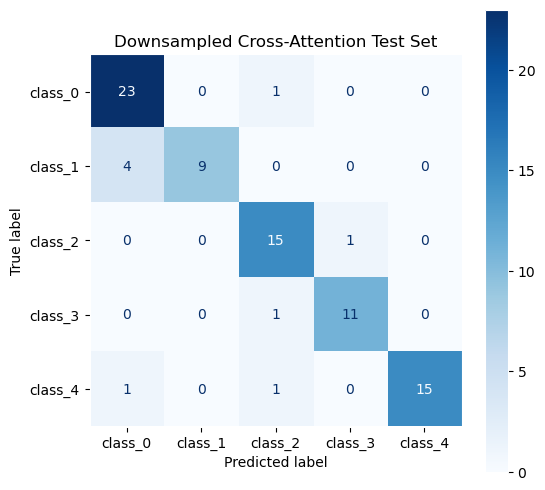

In [35]:
# with open("{prefix}/all_test_results.pkl", "rb") as f:
#     results = pickle.load(f)

results = all_test_results

foo = plot_cf(results, 'Downsampled Cross-Attention Test Set')
# foo.savefig('test.png', dpi=300)

# trying concatenation method of fusing

In [76]:
all_train_results = []
all_test_results = []
num_epochs = 5

# best_fold = None
# best_score = -np.inf
# best_model_state = None 

# Reinitialize model, loss, optimizer
model = MultimodalClassifier(fusion_method='fc_layer').to(device)# fc_layer, concatenate, cross_attend FOR L: concatenate.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train loop
train_results = train_model(
    model, 
    train_loader, 
    optimizer, 
    loss_fn, 
    device, 
    epochs=num_epochs,
    return_embeddings=True,
    save_prefix=prefix,
)
all_train_results.append(train_results)

best_model_state = model.state_dict()

Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Epoch 1/5 | Accuracy: 0.8079 | AUROC: 0.9593
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Epoch 2/5 | Accuracy: 0.8902 | AUROC: 0.9845
Performi

In [77]:
# save the best performing model on a particular fold
torch.save(best_model_state, f"{prefix}/best_model.pth")
print(f"Saved best model from training on 80% of the data.")

Saved best model from training on 80% of the data.


In [78]:
# Load the best model
best_model = MultimodalClassifier(fusion_method='fc_layer').to(device)
best_model.load_state_dict(torch.load(f"{prefix}/best_model.pth"))

<All keys matched successfully>

In [79]:
# Evaluate on test set
test_results = test_model(
    model=best_model,
    dataloader=test_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
    save_prefix=prefix,
)

all_test_results.append(test_results)

print(f"\nFinal Test Set Evaluation — Accuracy: {test_results['acc']:.4f}, AUROC: {test_results['auroc']:.4f}")

Performing fully connected layer fusion.
Performing fully connected layer fusion.
Performing fully connected layer fusion.
Accuracy: 0.8415 | AUROC: 0.9837

Final Test Set Evaluation — Accuracy: 0.8415, AUROC: 0.9837


In [80]:
# save the results for later confusion matrix plotting
with open(f"{prefix}/all_train_results.pkl", "wb") as f:
    pickle.dump(all_train_results, f)

with open(f"{prefix}/all_test_results.pkl", "wb") as f:
    pickle.dump(all_test_results, f)

# k-fold cross validation on the downsampled dataset

In [124]:
all_indices = list(range(len(balanced_dataset)))
trainval_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True) # fix the test set

test_dataset = Subset(balanced_dataset, test_idx)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# generate folds for train/val
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [129]:
# Perform 5-fold cross validation
all_train_results = []
all_val_results = []
num_epochs = 10

best_fold = None
best_score = -np.inf
best_model_state = None 

for fold, (train_idx, val_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\nFold {fold+1}")

    train_subset = Subset(balanced_dataset, [trainval_idx[i] for i in train_idx])
    val_subset   = Subset(balanced_dataset, [trainval_idx[i] for i in val_idx])

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Reinitialize model, loss, optimizer
    model = MultimodalClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Train loop
    train_results = train_model(
        model, 
        train_loader, 
        optimizer, 
        loss_fn, 
        device, 
        epochs=num_epochs,
        return_embeddings=True,
    )
    all_train_results.append(train_results)
    
    # Evaluate on validation set
    val_results = test_model(
        model, 
        val_loader, 
        loss_fn, 
        device,
    )
    all_val_results.append(val_results)

    if val_results['acc'] > best_score:
        best_score = val_results['acc']
        best_fold = fold
        best_model_state = model.state_dict()


Fold 1
fused=tensor([[ 0.1838,  0.2040, -1.0795,  ..., -1.1281, -1.0959, -0.0835],
        [ 0.7128,  0.0855, -0.5785,  ..., -1.0040, -0.8028, -0.3840],
        [ 0.6863,  0.9881,  1.0935,  ..., -1.1688,  0.1037, -1.0500],
        ...,
        [-0.1284, -0.2705, -0.9200,  ..., -1.2735, -1.0504,  0.1821],
        [-0.1040, -0.4207, -0.6261,  ..., -1.3738, -0.6088, -0.0248],
        [-0.0847, -0.2947, -0.0820,  ..., -1.4905, -1.0219, -0.0957]],
       device='cuda:0', grad_fn=<CatBackward0>)
fused=tensor([[ 2.1935, -0.2757,  0.1122,  ..., -0.4900, -1.2367,  0.3504],
        [ 1.6502, -0.2958, -0.1257,  ...,  0.3963, -1.2043,  0.2733],
        [ 0.4074,  0.0621, -0.5170,  ..., -1.6345, -1.8239,  0.4941],
        ...,
        [ 0.9796, -0.3289, -1.1719,  ..., -1.0798, -2.0546,  0.3528],
        [ 1.5064,  0.6266,  0.6369,  ...,  0.3518, -1.1122, -0.7426],
        [ 0.6393, -0.3326, -0.8006,  ..., -1.0011, -1.4156,  0.0133]],
       device='cuda:0', grad_fn=<CatBackward0>)
fused=tensor([[ 

In [130]:
# save the best performing model on a particular fold
torch.save(best_model_state, f"{prefix}/best_model.pth")
print(f"Saved best model from training on 80% of the data.")

# save the results for later confusion matrix plotting
with open(f"{prefix}/all_train_results.pkl", "wb") as f:
    pickle.dump(all_train_results, f)

with open(f"{prefix}/all_val_results.pkl", "wb") as f:
    pickle.dump(all_test_results, f)

Saved best model from training on 80% of the data.


In [132]:
# Load the best model from the 10-fold CV
best_model = MultimodalClassifier().to(device)
best_model.load_state_dict(torch.load(f"{prefix}/best_model.pth"))

# Evaluate on test set
test_results = test_model(
    model=best_model,
    dataloader=test_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
)
acc = test_results['acc']
auroc = test_results['auroc']
print(f"\nFinal Test Set Evaluation — Accuracy: {acc:.4f}, AUROC: {auroc:.4f}")

Accuracy: 0.9756 | AUROC: 0.9990

Final Test Set Evaluation — Accuracy: 0.9756, AUROC: 0.9990


In [133]:
with open(f"{prefix}/all_test_results.pkl", "wb") as f:
    pickle.dump(test_results, f)

In [165]:
with open("may10_F/all_train_results.pkl", "rb") as f:
    results = pickle.load(f)
results

[{'acc': 0.9847328244274809,
  'auroc': 0.9987720400423964,
  'preds': array([0, 2, 1, 4, 3, 1, 2, 2, 4, 3, 0, 4, 1, 1, 4, 1, 0, 2, 3, 2, 2, 2,
         2, 4, 3, 3, 4, 1, 0, 3, 3, 2, 2, 2, 3, 2, 0, 2, 1, 1, 1, 4, 0, 4,
         2, 0, 1, 4, 0, 0, 3, 0, 2, 1, 3, 2, 2, 2, 0, 0, 1, 0, 1, 3, 3, 0,
         2, 2, 1, 3, 0, 1, 3, 4, 4, 0, 4, 1, 1, 3, 4, 2, 3, 2, 1, 0, 0, 1,
         4, 1, 2, 2, 1, 3, 3, 0, 3, 2, 4, 2, 0, 3, 3, 1, 0, 3, 2, 3, 3, 2,
         4, 2, 1, 1, 3, 2, 0, 0, 3, 3, 4, 0, 2, 4, 0, 0, 1, 0, 0, 2, 2, 3,
         1, 1, 0, 2, 0, 3, 4, 1, 1, 1, 2, 1, 3, 3, 3, 3, 3, 2, 1, 2, 3, 1,
         2, 2, 3, 1, 3, 2, 0, 1, 0, 2, 3, 4, 1, 2, 4, 3, 1, 3, 3, 4, 1, 2,
         0, 1, 1, 2, 0, 3, 3, 4, 1, 0, 0, 1, 4, 3, 1, 4, 2, 2, 2, 4, 3, 2,
         3, 1, 2, 0, 4, 3, 4, 3, 3, 4, 3, 2, 0, 0, 4, 3, 1, 0, 2, 1, 2, 1,
         4, 0, 1, 1, 0, 0, 4, 4, 0, 1, 4, 4, 3, 1, 3, 3, 2, 4, 0, 1, 4, 3,
         0, 4, 0, 0, 1, 4, 3, 4, 1, 4, 0, 2, 3, 4, 4, 0, 0, 3, 0, 3]),
  'true': array([0, 2, 1, 4, 3, 1, 

In [164]:
print(f"Accuracy: {results[0]['acc']} | AUROC: {results[0]['auroc']}")
# print(f"Accuracy: {results['acc']} | AUROC: {results['auroc']}")

Accuracy: 0.8902439024390244 | AUROC: 0.9957821145988092


In [166]:
avg_acc = sum(x['acc'] for x in results) / len(results)
avg_auroc = sum(x['auroc'] for x in results) / len(results)
print(f'Average accuracy: {avg_acc} | Average AUROC: {avg_auroc}')

Average accuracy: 0.9573244710184889 | Average AUROC: 0.9976588013740392


# concatenation

In [136]:
# Perform 5-fold cross validation
all_train_results = []
all_val_results = []
num_epochs = 10

best_fold = None
best_score = -np.inf
best_model_state = None 

for fold, (train_idx, val_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\nFold {fold+1}")

    train_subset = Subset(balanced_dataset, [trainval_idx[i] for i in train_idx])
    val_subset   = Subset(balanced_dataset, [trainval_idx[i] for i in val_idx])

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Reinitialize model, loss, optimizer
    model = MultimodalClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Train loop
    train_results = train_model(
        model, 
        train_loader, 
        optimizer, 
        loss_fn, 
        device, 
        epochs=num_epochs,
        return_embeddings=True,
    )
    all_train_results.append(train_results)
    
    # Evaluate on validation set
    val_results = test_model(
        model, 
        val_loader, 
        loss_fn, 
        device,
    )
    all_val_results.append(val_results)

    if val_results['acc'] > best_score:
        best_score = val_results['acc']
        best_fold = fold
        best_model_state = model.state_dict()

# save the best performing model on a particular fold
torch.save(best_model_state, f"{prefix}/best_model.pth")
print(f"Saved best model from training on 80% of the data.")

# save the results for later confusion matrix plotting
with open(f"{prefix}/all_train_results.pkl", "wb") as f:
    pickle.dump(all_train_results, f)

with open(f"{prefix}/all_val_results.pkl", "wb") as f:
    pickle.dump(all_test_results, f)

# Load the best model from the 10-fold CV
best_model = MultimodalClassifier().to(device)
best_model.load_state_dict(torch.load(f"{prefix}/best_model.pth"))

# Evaluate on test set
test_results = test_model(
    model=best_model,
    dataloader=test_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
)
print(f"\nFinal Test Set Evaluation — Accuracy: {test_results['acc']:.4f}, AUROC: {test_results['auroc']:.4f}")

with open(f"{prefix}/all_test_results.pkl", "wb") as f:
    pickle.dump(test_results, f)


Fold 1
fused=tensor([[0.5976, 0.3442, 0.5602,  ..., 1.7036, 0.3243, 0.3027],
        [1.4540, 4.1130, 0.4458,  ..., 1.5899, 0.2565, 0.2895],
        [2.6354, 2.7962, 2.2597,  ..., 1.5012, 0.0310, 0.3051],
        ...,
        [2.3420, 1.1847, 1.2526,  ..., 1.4739, 0.6264, 0.2099],
        [4.3544, 5.6823, 3.6131,  ..., 1.0960, 0.5666, 0.1409],
        [2.5052, 1.3767, 0.1608,  ..., 1.6954, 0.3154, 0.3024]],
       device='cuda:0', grad_fn=<CatBackward0>)
fused=tensor([[2.0752, 3.2500, 1.8032,  ..., 1.4923, 0.5380, 0.2279],
        [2.0055, 3.1230, 0.3143,  ..., 1.4294, 0.7808, 0.1780],
        [0.4950, 0.3530, 1.3951,  ..., 1.2017, 0.4840, 0.1760],
        ...,
        [0.3696, 0.9734, 1.2706,  ..., 1.2110, 0.6183, 0.1575],
        [4.0255, 1.2571, 0.6176,  ..., 1.5221, 0.4876, 0.2417],
        [2.3220, 0.1076, 4.4309,  ..., 1.6283, 0.4271, 0.2728]],
       device='cuda:0', grad_fn=<CatBackward0>)
fused=tensor([[2.4502, 1.1645, 0.0930,  ..., 1.4210, 0.8275, 0.1701],
        [1.9728, 2

# fc-layer

In [138]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__() # inherit from nn.Module
        self.attn = nn.MultiheadAttention(embed_dim = dim, num_heads = num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        self.feedforward = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim),
        )
        self.norm_feedforward = nn.LayerNorm(dim)

    def forward(self, q, kv):
        # architecture is standard transformer encoder block: attn -> add+norm -> mlp -> add+norm
        attn_output, attn_output_weights = self.attn(q, kv, kv) # in cross attention, let one modality (q) attend to another (kv)
        x = self.norm(q + attn_output) # residual connection
        ff_output = self.feedforward(x) # mlp
        return self.norm_feedforward(x + ff_output) # residual connection

class BidirectionalCrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.img_to_tab = CrossAttentionBlock(dim, num_heads, dropout)
        self.tab_to_img = CrossAttentionBlock(dim, num_heads, dropout)
        # return img_out, tab_out

    def forward(self, img_embed, tab_embed):
        img_out = self.img_to_tab(img_embed, tab_embed)
        tab_out = self.tab_to_img(tab_embed, img_embed)
        return img_out, tab_out
        
class MultimodalClassifier(nn.Module):
    def __init__(self, embed_dim=512, num_heads=4):
        super().__init__() # inherit

        # image encoder -- acquire the img embeddings from finetuned resnet
        resnet = models.resnet18(weights='DEFAULT')
        resnet.fc = nn.Linear(resnet.fc.in_features, 5)
        resnet.load_state_dict(torch.load("resnet_finetuned.pth"))
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.image_encoder.eval()
        for param in self.image_encoder.parameters(): # fix the resnet weights
            param.requires_grad = False

        # cross attention
        self.cross_attn = BidirectionalCrossAttention(dim=embed_dim, num_heads=num_heads)

        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, 5) # 5 total classes to predict upon
        )

        # linear layer for combining multimodal data
        self.fc_combine = nn.Linear(embed_dim * 2, embed_dim * 2)

        self.scalar_projector = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.LayerNorm(embed_dim)
        )

    def forward(self, images, tabular):
        fused = self.get_embeddings(images, tabular, kind='fc_layer') # kind can be one of {'cross_attend', 'concatenate', 'fc_layer'}
        logits = self.classifier(fused) # [B, num_classes]
        return logits, fused
        
    def get_embeddings(self, images, tabular, kind='fc_layer'):
        # image encoding
        self.image_encoder.eval()
        B = images.size(0)
        x = self.image_encoder(images) # shape: [B, 512, 7, 7]
        # print("NaNs in image encoder output:", torch.isnan(x).any(), x.mean(), x.std())
        img_embed = x.flatten(2).permute(0, 2, 1) # [B, 49, 512]
        
        # tabular encoding
        tab_embed = []
        for i in range(tabular.shape[1]):
            feat = tabular[:, i].unsqueeze(-1)  # [B, 1]
            emb = self.scalar_projector(feat)   # [B, D]
            tab_embed.append(emb)
        tab_embed = torch.stack(tab_embed, dim=1)  # [B, num_features, D]

        # attempting different methods of combining the encodings
        ## bidirectional cross attention
        if kind == 'cross_attend':
            img_updated, tab_updated = self.cross_attn(img_embed, tab_embed)
            img_pooled = img_updated.mean(dim=1) # [B, D]
            tab_pooled = tab_updated.mean(dim=1) # [B, D]
    
            fused = torch.cat([img_pooled, tab_pooled], dim=1) # [B, 2D]

        # ## concatenation
        if kind == 'concatenate':
            img_pooled = img_embed.mean(dim=1)  # [B, 512]
            tab_pooled = tab_embed.mean(dim=1)  # [B, 512]
            
            fused = torch.cat([img_pooled, tab_pooled], dim=1)  # [B, 1024]
        
        # ## fully connected layer
        if kind == 'fc_layer':
            img_pooled = img_embed.mean(dim=1)  # [B, 512]
            tab_pooled = tab_embed.mean(dim=1)  # [B, 512]
            
            fused = torch.cat([img_pooled, tab_pooled], dim=1)  # [B, 1024]
            fused = self.fc_combine(fused)
 
        return fused

In [139]:
# Perform 5-fold cross validation
all_train_results = []
all_val_results = []
num_epochs = 10

best_fold = None
best_score = -np.inf
best_model_state = None 

for fold, (train_idx, val_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\nFold {fold+1}")

    train_subset = Subset(balanced_dataset, [trainval_idx[i] for i in train_idx])
    val_subset   = Subset(balanced_dataset, [trainval_idx[i] for i in val_idx])

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Reinitialize model, loss, optimizer
    model = MultimodalClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Train loop
    train_results = train_model(
        model, 
        train_loader, 
        optimizer, 
        loss_fn, 
        device, 
        epochs=num_epochs,
        return_embeddings=True,
    )
    all_train_results.append(train_results)
    
    # Evaluate on validation set
    val_results = test_model(
        model, 
        val_loader, 
        loss_fn, 
        device,
    )
    all_val_results.append(val_results)

    if val_results['acc'] > best_score:
        best_score = val_results['acc']
        best_fold = fold
        best_model_state = model.state_dict()

# save the best performing model on a particular fold
torch.save(best_model_state, f"{prefix}/best_model.pth")
print(f"Saved best model from training on 80% of the data.")

# save the results for later confusion matrix plotting
with open(f"{prefix}/all_train_results.pkl", "wb") as f:
    pickle.dump(all_train_results, f)

with open(f"{prefix}/all_val_results.pkl", "wb") as f:
    pickle.dump(all_test_results, f)

# Load the best model from the 10-fold CV
best_model = MultimodalClassifier().to(device)
best_model.load_state_dict(torch.load(f"{prefix}/best_model.pth"))

# Evaluate on test set
test_results = test_model(
    model=best_model,
    dataloader=test_loader,
    loss_fn=torch.nn.CrossEntropyLoss(),
    device=device,
)
print(f"\nFinal Test Set Evaluation — Accuracy: {test_results['acc']:.4f}, AUROC: {test_results['auroc']:.4f}")

with open(f"{prefix}/all_test_results.pkl", "wb") as f:
    pickle.dump(test_results, f)


Fold 1
fused=tensor([[-1.1446, -0.6370,  0.3656,  ...,  0.8777,  0.1082, -0.8668],
        [-0.9871, -0.8034,  0.1519,  ...,  0.8256,  0.3841, -0.4677],
        [-1.5197, -1.4151, -0.4617,  ...,  0.3665, -0.4854, -0.7347],
        ...,
        [-0.9916, -0.3438, -0.0425,  ...,  0.3746,  0.0742, -0.9628],
        [-1.3285, -0.7678, -0.6775,  ...,  0.4832, -0.6230, -0.5989],
        [-1.9610, -0.8169, -0.4694,  ...,  0.5598, -0.6579, -0.3605]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
fused=tensor([[-1.9602, -1.4085, -1.0180,  ...,  0.6612,  0.4177, -0.4881],
        [-1.8612, -1.6704, -0.6781,  ...,  0.2257,  0.8715,  0.2021],
        [-3.1960, -2.3221, -0.6173,  ...,  1.5228,  0.9030,  0.2911],
        ...,
        [-1.6134, -1.4750, -0.5832,  ...,  0.7307,  0.6689,  0.5253],
        [-1.8888, -1.5242, -0.6930,  ...,  0.7435,  0.9009,  0.3264],
        [-2.4514, -1.9975, -1.1487,  ...,  1.1123, -0.3967, -0.5582]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
fused=tensor